# Filtering & gridding of crowdsourced data
### This notebook creates a climada hazard set from the filtered (point-based) crowdsourced reports


In [1]:
#Load packages
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import datetime as dt
from climada import CONFIG
import scClim as sc

data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)
version = 27
population_path = f'{data_dir}/ch_shapefile/population_data/STATPOP2021.csv'

In [2]:
#population pre-processing (aggregate to 1km grid)
population = pd.read_csv(population_path,sep=';')
population['chx'] = np.round(population['E_KOORD']//1000)*1000 +500
population['chy'] = np.round(population['N_KOORD']//1000)*1000 +500

pop_sum = population.groupby(['chx','chy']).agg({'B21BTOT': 'sum'})
pop_sum = pop_sum.reset_index()

In [ ]:
#Load crowdsourced data
crowd_data = pd.read_csv(f'{data_dir}/crowd-source/crowd_processed_paper.csv',parse_dates=['time_dt','hailday'])
crowd_data['hailday'] = crowd_data.hailday.dt.date # Convert datetime to date

#Remove all entries before (and including) July 2020
crowd_data = crowd_data[crowd_data.hailday.apply(pd.Timestamp).dt.date >= dt.date(2020,8,1)]
#Only keep values within hail season April-September
crowd_data = crowd_data[crowd_data.hailday.apply(pd.Timestamp).dt.month.isin([4,5,6,7,8,9])]
#remove no hail category
crowd_data = crowd_data.loc[crowd_data.size_text!='No hail']
print("Total number of unfiltered reports: ",crowd_data.shape[0])


#Coffe bean reports must be within POH
cond1 = crowd_data.size_mm.between(2.5,6.5) & (crowd_data.maxBZC_t15_r4>0) # 2.5mm="<coffe bean", 6.5mm ="coffe bean"
print(f"Removed based on POH: {((crowd_data.size_mm.between(2.5,6.5)) & ~(crowd_data.maxBZC_t15_r4>0)).sum()}")
#1 Franc and larger must be within MESHS
cond2 = (crowd_data.size_mm>=23) & (crowd_data.maxMZC_t15_r4>0)
print(f"Removed based on MESHS: {((crowd_data.size_mm>=23) & ~(crowd_data.maxMZC_t15_r4>0)).sum()}")

if version <40:
    print(f"Removed {crowd_data.shape[0]-crowd_data.loc[cond1|cond2].shape[0]} reports (including MESHS,POH,'no hail' category)")
    crowd_data = crowd_data.loc[cond1|cond2]

else:
    #only filter by DBZ
    crowd_data = crowd_data.loc[crowd_data['FILTEREDOUT']==0]



#Select DBSCAN parameters (from Kopp et al. 2024)
dx=8000; d_min = 8; d_size = 1.5

#Prepare data for DBSCAN
crowd_data["time_int"] = crowd_data.time_dt.astype("int64")//10**9
crowd_data["time_int"] = crowd_data["time_int"] - crowd_data["time_int"].min()
X = crowd_data[['chx','chy','time_int','size']].values
X = sc.crowd_process.per_category_scaler(X,min_dist_p_category=[dx,dx,d_min*60,d_size]) # km,km, s, #size_categories

#DBSCAN clustering
dbscan = DBSCAN(eps=1,min_samples=5)
dbscan.fit(X)
crowd_data['cluster'] = dbscan.labels_
crowd_data_cluster = crowd_data.copy(deep=True) #Create copy for later plotting
print(f"Remove {crowd_data[crowd_data.cluster==-1].shape[0]} not-clustered reports")
crowd_data = crowd_data[crowd_data.cluster!=-1]




C:\Users\timschmi\AppData\Local\Temp\ipykernel_7976\2438538077.py:2: DtypeWarning: Columns (10,11,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  crowd_data = pd.read_csv(f'{data_dir}/crowd-source/crowd_processed_paper.csv',parse_dates=['time_dt','hailday'])


Total number of unfiltered reports:  180478
Removed based on POH: 36390
Removed based on MESHS: 21964
Removed 58381 reports (including MESHS,POH,'no hail' category)
Remove 15873 not-clustered reports


Pecentage of reports during days with >25 reports/day: 99.4%


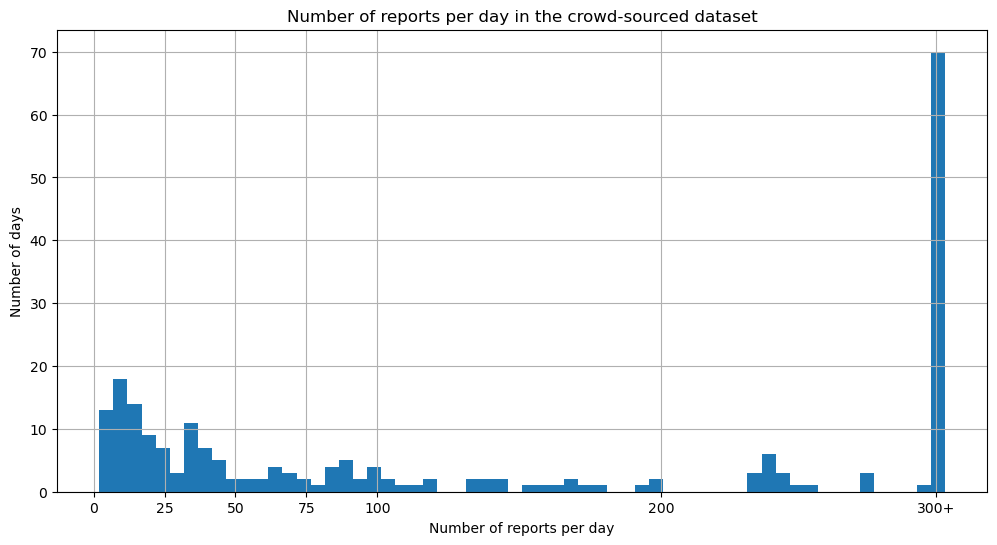

In [ ]:
#Plot the number of reports per day as histogram
rep_p_day = crowd_data.groupby('hailday').size().sort_values()

fig,ax = plt.subplots(1,1,figsize=(12,6))
rep_p_day.clip(0,300).hist(bins=60)
_=ax.set(ylabel='Number of days',xlabel='Number of reports per day',
       xticks=[0,25,50,75,100,200,297],xticklabels=["0","25","50","75","100","200","300+"],
       title='Number of reports per day in the crowd-sourced dataset')


print(f"Pecentage of reports during days with >25 reports/day: {rep_p_day[rep_p_day>25].sum()/rep_p_day.sum()*100:.1f}%")

In [ ]:
#Create gridded dataset
if version == 27:
    ds25 = sc.crowd_process.grid_crowd_source_TS(crowd_data,population_path,date_sel='all', min_crowd_count=25,k_size=7,gauss_sigma=1.0,min_rep_density=0.0005,size_agg='max',w_pop=0.25,w_n_rep=1,rep_density_var="rep_density_within_kernel_weigh")


#Save gridded xr dataset
print(f'There are {len(ds25.time)} days with at least 25 reports')
ds25.to_netcdf(f'{data_dir}/crowd-source/Reports_min25_2020+_V{version}.nc')

20200801
20200802
20200810
20200811
20200812
20200813
20200814
20200816
20200817
20200818
20200828
20200830
20200831
20200916
20200920
20200921
20200924
20200925
20210502
20210514
20210518
20210519
20210524
20210604
20210605
20210606
20210608
20210609
20210617
20210618
20210620
20210621
20210622
20210623
20210624
20210627
20210628
20210629
20210708
20210710
20210712
20210713
20210724
20210725
20210726
20210730
20210731
20210803
20210812
20210815
20210816
20210821
20210904
20220426
20220430
20220503
20220504
20220505
20220507
20220515
20220516
20220519
20220520
20220522
20220523
20220601
20220603
20220604
20220605
20220606
20220607
20220615
20220616
20220619
20220621
20220622
20220623
20220624
20220625
20220626
20220627
20220628
20220630
20220703
20220704
20220705
20220719
20220720
20220722
20220723
20220725
20220726
20220728
20220805
20220806
20220807
20220815
20220817
20220826
20220830
20220901
20220902
20220903
20220906
20220907
20220909
20220914
20220924
20230413
20230423
20230425
2

In [ ]:
ds_save = ds25.drop_vars(["rep_density_within_kernel","n_rep_within_kernel",
                        "rep_density_within_kernel_weigh","pop"])
ds_save = ds_save.rename({"n_rep":"n_reports",
                        "h_smooth":"hail_size",
                        "h_raw":"hail_size_raw"})
ds_save.n_reports.attrs = {"long_name":"Number of crowdsourced reports", "unit":"-"}
ds_save.hail_size.attrs = {"long_name":"Gridded hail size from crowdsourced reports",
                                "unit":"mm"}
ds_save.hail_size_raw.attrs = {"long_name":("Non-interpolated (raw) hail size for each grid cell. "
                                                "Derived from max. size of crowdsourced reports within the cell"),
                                    "unit":"mm"}
description = ("Gridded dataset of crowdsourced hail reports from August 2020 "
            "to September 2023. The data only contains days with at least "
            "25 reports. Coordinates in EPSG:2056 (chx,chy). The primary "
            "variable is 'hail_size'. Additionally the data contains the"
            "non-interpolated hail size 'hail_size_raw' and the number of "
            "crowdsourced reports per grid cell 'n_reports'.")

ds_save.attrs = {"Data description": description, "Author":"Timo Schmid",
                "Contact":"timo.schmid@usys.ethz.ch"}


ds_save.to_netcdf(f'{data_dir}/crowd-source/crowdsourced_hail_size_Aug2020-Sept2023.nc',
                encoding={"hail_size":        {'zlib': True, 'complevel': 5},
                            "hail_size_raw":    {'zlib': True, 'complevel': 5},
                            "n_reports":        {'zlib': True, 'complevel': 5}})
ds_save

<xarray.Dataset>
Dimensions:        (time: 169, chy: 226, chx: 354)
Coordinates:
  * time           (time) datetime64[ns] 2020-08-01 2020-08-02 ... 2023-09-22
  * chx            (chx) int32 2484500 2485500 2486500 ... 2836500 2837500
  * chy            (chy) int32 1073500 1074500 1075500 ... 1297500 1298500
    lon            (chy, chx) float64 5.954 5.967 5.98 ... 10.58 10.6 10.61
    lat            (chy, chx) float64 45.8 45.8 45.8 45.8 ... 47.8 47.8 47.8
Data variables:
    hail_size_raw  (time, chy, chx) float64 nan nan nan nan ... nan nan nan nan
    n_reports      (time, chy, chx) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hail_size      (time, chy, chx) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Data description:  Gridded dataset of crowdsourced hail reports from Augu...
    Author:            Timo Schmid
    Contact:           timo.schmid@usys.ethz.ch

<GeoAxesSubplot:title={'center':'Event ID 152: ev_2023-07-24'}>

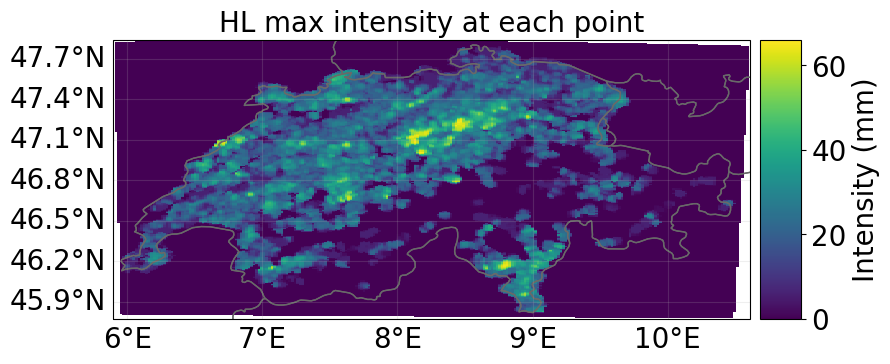

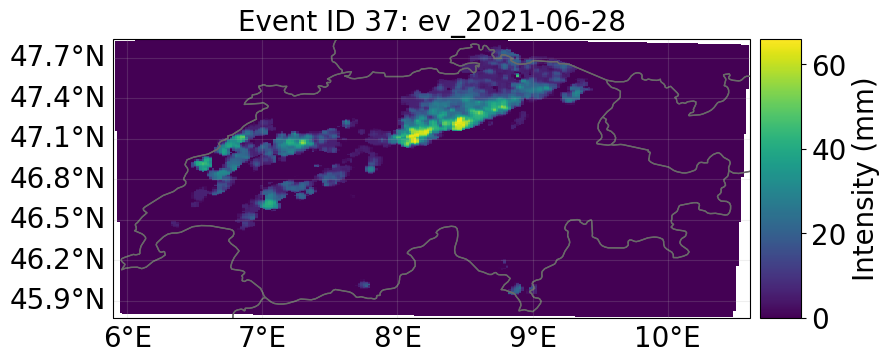

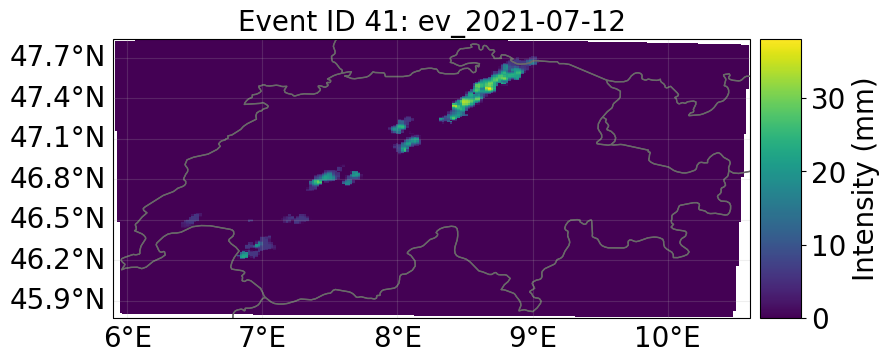

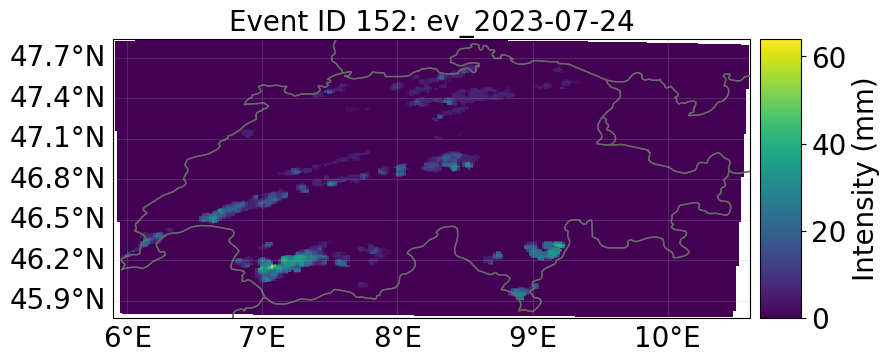

In [27]:
#Round to integers
ds_haz = ds25.round(decimals=0)


#Convert to climada.Hazard object
haz = sc.hazard_from_radar(ds_haz,'crowd')
haz.plot_intensity(0)

# Plot some examples
haz.plot_intensity(haz.event_id[haz.date==dt.datetime(2021,6,28).toordinal()][0])
haz.plot_intensity(haz.event_id[haz.date==dt.datetime(2021,7,12).toordinal()][0])
haz.plot_intensity(haz.event_id[haz.date==dt.datetime(2023,7,24).toordinal()][0])


In [7]:
haz.write_hdf5(f'{data_dir}/crowd-source/hazard_min25_2020+_V{version}.h5')

C:\Users\timschmi\AppData\Local\Temp\ipykernel_7976\1822304935.py:4: DtypeWarning: Columns (10,11,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  crowd_raw = pd.read_csv(f'{data_dir}/crowd-source/crowd_processed_paper.csv',parse_dates=['time_dt','hailday'])


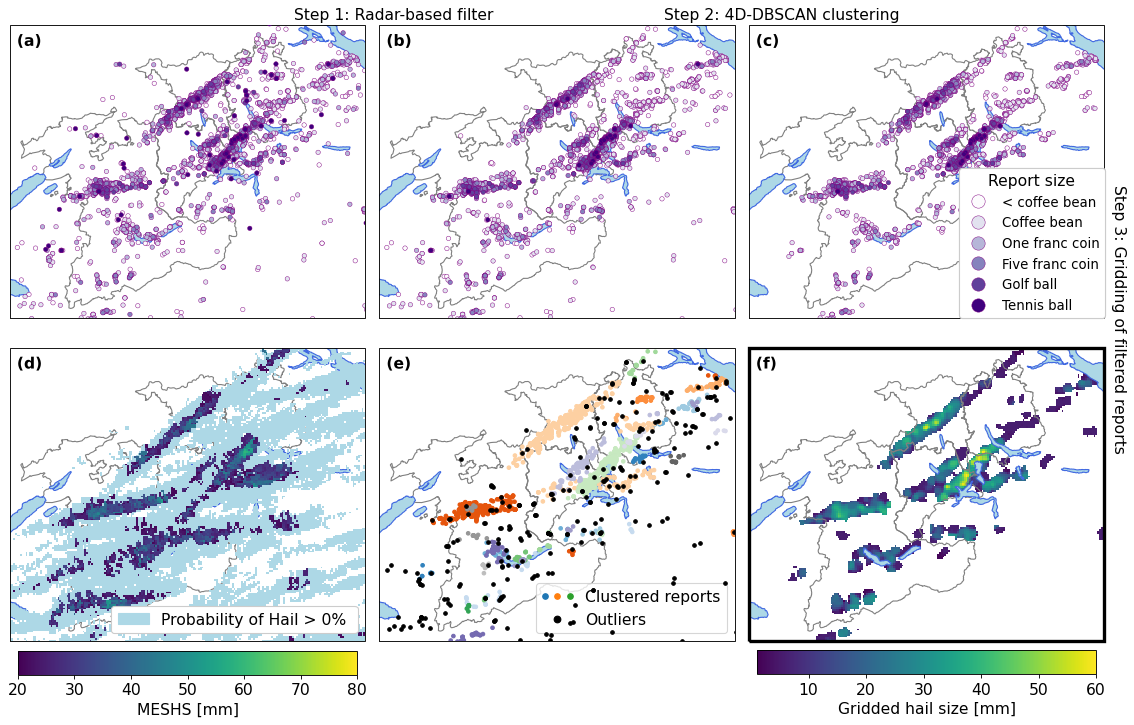

In [ ]:
ds_haz= xr.open_dataset(f'{data_dir}/crowd-source/Reports_min25_2020+_V{version}.nc').round(decimals=0)

crowd_raw = pd.read_csv(f'{data_dir}/crowd-source/crowd_processed_paper.csv',parse_dates=['time_dt','hailday'])
crowd_raw['hailday'] = crowd_raw.hailday.dt.date # Convert datetime to date
date = dt.date(2023,7,12)
sc.plot_funcs.plot_filtering_V2(date,crowd_data_cluster,crowd_raw,ds_haz,fs=14,title=False)
plt.savefig(f'{out_dir}/paper_crowd/filtering_{date.strftime("%Y-%m-%d")}_V2.png',dpi=300,bbox_inches='tight')